# 🎯 Bollinger Bands Backtest Engine - EURGBP

## Descrizione
Sistema di backtest avanzato per la strategia **Bollinger Bands Mean Reversion** su dati tick reali EURGBP.

## Caratteristiche Principali
- ✅ **Esecuzione realistica**: Bid/Ask pricing, no slippage idealizzato
- ✅ **Gestione corretta exit+entry**: Nella stessa candela gestisce prima l'exit, poi il nuovo entry
- ✅ **Stop Loss dinamico**: Stop loss configurabile per ogni posizione
- ✅ **Ottimizzazione Numba**: Performance elevate (>350k bars/sec)
- ✅ **Analisi dettagliate**: Grafici interattivi, analisi spread, statistics avanzate

## Strategia Bollinger Bands
- **LONG**: Quando `close < lower_band` → Buy all'ASK, Exit al BID quando `close ≥ middle_band`
- **SHORT**: Quando `close > upper_band` → Sell al BID, Exit all'ASK quando `close ≤ middle_band`
- **Stop Loss**: Configurabile in pips, eseguito con pricing realistico

## Come usare
1. **Configura parametri** nella prima cella
2. **Esegui tutte le celle** in sequenza 
3. **Analizza risultati** nei grafici e statistiche finali

## Dati
- **Fonte**: Tick data reali EURGBP (gennaio-aprile 2025)
- **Resampling**: Tick → Candele 1min con bid/ask finale
- **Volume**: ~5.5M tick → ~92k candele 1min

In [35]:
# ⚙️ CONFIGURAZIONE PARAMETRI BOLLINGER BANDS BACKTEST
# =============================================================================
# Modifica questi parametri per ottimizzare la strategia
# =============================================================================

print("🎛️ CONFIGURAZIONE PARAMETRI BOLLINGER BANDS")
print("=" * 60)

# 📊 PARAMETRI BOLLINGER BANDS
BB_PERIOD = 400             # Periodo per media mobile (tipicamente 20)
BB_STD_DEV = 1.0           # Deviazioni standard (tipicamente 2.0)

# 📈 PARAMETRI STRATEGIA  
ENABLE_LONG = True         # Abilita posizioni LONG
ENABLE_SHORT = True        # Abilita posizioni SHORT

# 🎯 PARAMETRI ESECUZIONE
MIN_SPREAD_PIPS = 0.0      # Spread minimo per eseguire trade (0 = nessun filtro)
MAX_SPREAD_PIPS = 5.0      # Spread massimo per eseguire trade (5 pips)
STOP_LOSS_PIPS = 100       # Stop loss in pips per ogni trade

# 📊 STAMPA CONFIGURAZIONE
print(f"📊 Bollinger Bands:")
print(f"   • Periodo: {BB_PERIOD}")
print(f"   • Deviazioni Standard: {BB_STD_DEV}")
print(f"📈 Strategia:")
print(f"   • Long abilitati: {'✅' if ENABLE_LONG else '❌'}")
print(f"   • Short abilitati: {'✅' if ENABLE_SHORT else '❌'}")
print(f"🎯 Filtri Esecuzione:")
print(f"   • Spread minimo: {MIN_SPREAD_PIPS} pips")
print(f"   • Spread massimo: {MAX_SPREAD_PIPS} pips")
print(f"   • Stop Loss: {STOP_LOSS_PIPS} pips")
print("=" * 60)
print("✅ Parametri configurati! Procedi con l'esecuzione del backtest.")
print("💡 TIP: Modifica i valori sopra e ri-esegui tutte le celle per testare nuovi parametri.")

🎛️ CONFIGURAZIONE PARAMETRI BOLLINGER BANDS
📊 Bollinger Bands:
   • Periodo: 400
   • Deviazioni Standard: 1.0
📈 Strategia:
   • Long abilitati: ✅
   • Short abilitati: ✅
🎯 Filtri Esecuzione:
   • Spread minimo: 0.0 pips
   • Spread massimo: 5.0 pips
   • Stop Loss: 100 pips
✅ Parametri configurati! Procedi con l'esecuzione del backtest.
💡 TIP: Modifica i valori sopra e ri-esegui tutte le celle per testare nuovi parametri.


In [36]:
import pandas as pd
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Ricarico i dati dopo restart del kernel
data = '/home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/eurgbp_1monthTick.csv'
df = pd.read_csv(data)
print(f"Dati ricaricati: {df.shape[0]} tick da {df['timestamp'].min()} a {df['timestamp'].max()}")

Dati ricaricati: 5572578 tick da 2025-01-01 22:04:01 a 2025-04-01 23:59:49


In [37]:
# Preparazione dati tick per resampling realistico
print("🔄 Preparazione dati tick...")

# Conversione timestamp e ordinamento
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# Calcolo mid price per le candele
df['mid_price'] = (df['askPrice'] + df['bidPrice']) / 2

# Set timestamp come index per resampling
df_indexed = df.set_index('timestamp')

print(f"✅ Dati preparati: {len(df_indexed)} tick ordinati cronologicamente")
print(f"Periodo: {df_indexed.index.min()} → {df_indexed.index.max()}")
print(f"Spread medio: {(df_indexed['askPrice'] - df_indexed['bidPrice']).mean()*10000:.1f} pips")
print(f"Spread min/max: {(df_indexed['askPrice'] - df_indexed['bidPrice']).min()*10000:.1f}/{(df_indexed['askPrice'] - df_indexed['bidPrice']).max()*10000:.1f} pips")

🔄 Preparazione dati tick...
✅ Dati preparati: 5572578 tick ordinati cronologicamente
Periodo: 2025-01-01 22:04:01 → 2025-04-01 23:59:49
Spread medio: 0.9 pips
Spread min/max: 0.1/32.9 pips
✅ Dati preparati: 5572578 tick ordinati cronologicamente
Periodo: 2025-01-01 22:04:01 → 2025-04-01 23:59:49
Spread medio: 0.9 pips
Spread min/max: 0.1/32.9 pips


In [38]:
# Resampling a candele 1min mantenendo bid/ask
print("🕐 Resampling tick → candele 1min...")

# Resampling mantenendo OHLC per mid_price + ultimo bid/ask
ohlc_data = df_indexed['mid_price'].resample('1T').agg({
    'open': 'first',
    'high': 'max', 
    'low': 'min',
    'close': 'last'
}).dropna()

# Per ogni candela, prendo l'ultimo bid/ask disponibile (più realistico)
bid_ask_data = df_indexed[['askPrice', 'bidPrice']].resample('1T').agg({
    'askPrice': 'last',  # Ultimo ask del minuto
    'bidPrice': 'last'   # Ultimo bid del minuto  
}).dropna()

# Combino i dati
candles = pd.concat([ohlc_data, bid_ask_data], axis=1).dropna()

print(f"✅ {len(candles)} candele 1min create")
print(f"Periodo candele: {candles.index[0]} → {candles.index[-1]}")
print(f"Dati candele completi: OHLC + bid/ask finale per ogni minuto")

# Visualizzo alcune candele
print("\n📊 Prime 5 candele:")
print(candles.head())

🕐 Resampling tick → candele 1min...
✅ 91984 candele 1min create
Periodo candele: 2025-01-01 22:04:00 → 2025-04-01 23:59:00
Dati candele completi: OHLC + bid/ask finale per ogni minuto

📊 Prime 5 candele:
                         open      high       low     close  askPrice  \
timestamp                                                               
2025-01-01 22:04:00  0.826920  0.827110  0.826880  0.827070   0.82795   
2025-01-01 22:05:00  0.826785  0.827325  0.826635  0.827325   0.82790   
2025-01-01 22:06:00  0.827320  0.827380  0.827255  0.827340   0.82795   
2025-01-01 22:07:00  0.827320  0.827325  0.827245  0.827245   0.82784   
2025-01-01 22:08:00  0.827245  0.827290  0.827240  0.827285   0.82783   

                     bidPrice  
timestamp                      
2025-01-01 22:04:00   0.82619  
2025-01-01 22:05:00   0.82675  
2025-01-01 22:06:00   0.82673  
2025-01-01 22:07:00   0.82665  
2025-01-01 22:08:00   0.82674  
✅ 91984 candele 1min create
Periodo candele: 2025-01-01 22:0

In [39]:
# Calcolo Bollinger Bands ottimizzato
print("📈 Calcolo Bollinger Bands...")

def calculate_bollinger_bands(prices, window=20, std_dev=2):
    """Calcolo vettorizzato delle Bollinger Bands"""
    # Rolling mean
    middle_band = prices.rolling(window=window).mean()
    
    # Rolling standard deviation  
    rolling_std = prices.rolling(window=window).std()
    
    # Bande superiore e inferiore
    upper_band = middle_band + (rolling_std * std_dev)
    lower_band = middle_band - (rolling_std * std_dev)
    
    return middle_band, upper_band, lower_band

# Calcolo Bollinger Bands sui close usando parametri configurabili
middle_band, upper_band, lower_band = calculate_bollinger_bands(
    candles['close'], 
    window=BB_PERIOD, 
    std_dev=BB_STD_DEV
)

# Aggiungo alle candele
candles['bb_middle'] = middle_band
candles['bb_upper'] = upper_band  
candles['bb_lower'] = lower_band

# Rimuovo righe con NaN (primi 20 valori)
candles = candles.dropna()

print(f"✅ Bollinger Bands calcolate per {len(candles)} candele")
print(f"Periodo backtest: {candles.index[0]} → {candles.index[-1]}")
print(f"Campioni validi per trading: {len(candles)}")

# Mostro esempio delle bande
print("\n📊 Esempio candele con Bollinger Bands:")
print(candles[['close', 'bb_lower', 'bb_middle', 'bb_upper', 'askPrice', 'bidPrice']].head())

📈 Calcolo Bollinger Bands...
✅ Bollinger Bands calcolate per 91585 candele
Periodo backtest: 2025-01-02 04:43:00 → 2025-04-01 23:59:00
Campioni validi per trading: 91585

📊 Esempio candele con Bollinger Bands:
                        close  bb_lower  bb_middle  bb_upper  askPrice  \
timestamp                                                                
2025-01-02 04:43:00  0.827205  0.827089   0.827297  0.827506   0.82725   
2025-01-02 04:44:00  0.827220  0.827089   0.827298  0.827506   0.82726   
2025-01-02 04:45:00  0.827245  0.827089   0.827297  0.827506   0.82728   
2025-01-02 04:46:00  0.827275  0.827089   0.827297  0.827505   0.82731   
2025-01-02 04:47:00  0.827365  0.827089   0.827298  0.827506   0.82741   

                     bidPrice  
timestamp                      
2025-01-02 04:43:00   0.82716  
2025-01-02 04:44:00   0.82718  
2025-01-02 04:45:00   0.82721  
2025-01-02 04:46:00   0.82724  
2025-01-02 04:47:00   0.82732  


In [42]:
# Backtest Engine Ottimizzato con Numba - Gestione corretta exit+entry
print("⚡ Preparazione backtest engine ottimizzato...")

@jit(nopython=True)
def bollinger_backtest_engine(closes, bb_upper, bb_lower, bb_middle, ask_prices, bid_prices, 
                             enable_long=True, enable_short=True, min_spread=0.0, max_spread=5.0, stop_loss_pips=100):
    """
    Backtest engine ottimizzato che gestisce correttamente exit+entry nella stessa candela
    
    CARATTERISTICHE:
    - Gestione corretta della sequenza: exit → new entry nella stessa candela
    - Evita sovrapposizioni e conflitti di posizioni
    - Esecuzione realistica con bid/ask pricing
    - Stop loss dinamico per ogni posizione
    
    Strategia Bollinger Bands:
    - LONG: quando close < lower_band (buy ask, exit bid at middle OR stop loss)
    - SHORT: quando close > upper_band (sell bid, exit ask at middle OR stop loss)
    """
    n = len(closes)
    
    # Arrays per risultati
    positions = np.zeros(n)  # 0=flat, 1=long, -1=short
    entry_prices = np.zeros(n)
    exit_prices = np.zeros(n)
    pnl_pips = np.zeros(n)
    equity_curve = np.zeros(n)
    exit_reasons = np.zeros(n)  # 0=no exit, 1=target, 2=stop loss
    
    # Stato trading
    current_position = 0
    entry_price = 0.0
    equity = 0.0
    stop_loss_price = 0.0
    
    for i in range(1, n):  # Start from 1 to avoid look-ahead bias
        close_price = closes[i-1]  # Uso close della candela precedente (evito look-ahead)
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        current_middle = bb_middle[i]
        
        # Calcolo spread corrente in pips
        current_spread = (current_ask - current_bid) * 10000
        
        # STEP 1: Controllo EXIT se in posizione
        if current_position != 0:
            exit_condition = False
            exit_reason = 0
            
            if current_position == 1:  # Long position
                # CONTROLLO STOP LOSS PRIMA (priorità)
                if current_bid <= stop_loss_price:
                    exit_price = current_bid  # Vendo al bid (realistico)
                    pnl = (exit_price - entry_price) * 10000  # Pips
                    exit_condition = True
                    exit_reason = 2  # Stop loss
                    
                # CONTROLLO TARGET (middle band)
                elif close_price >= current_middle:
                    exit_price = current_bid  # Vendo al bid
                    pnl = (exit_price - entry_price) * 10000  # Pips
                    exit_condition = True
                    exit_reason = 1  # Target
                    
            elif current_position == -1:  # Short position  
                # CONTROLLO STOP LOSS PRIMA (priorità)
                if current_ask >= stop_loss_price:
                    exit_price = current_ask  # Compro all'ask (realistico)
                    pnl = (entry_price - exit_price) * 10000  # Pips
                    exit_condition = True
                    exit_reason = 2  # Stop loss
                    
                # CONTROLLO TARGET (middle band)
                elif close_price <= current_middle:
                    exit_price = current_ask  # Compro all'ask
                    pnl = (entry_price - exit_price) * 10000  # Pips
                    exit_condition = True
                    exit_reason = 1  # Target
            
            # Se c'è exit, lo eseguo e resetto lo stato
            if exit_condition:
                pnl_pips[i] = pnl
                exit_prices[i] = exit_price
                exit_reasons[i] = exit_reason
                equity += pnl
                current_position = 0
                entry_price = 0.0
                stop_loss_price = 0.0
        
        # STEP 2: Controllo ENTRY (solo se non in posizione e spread accettabile)
        if current_position == 0 and min_spread <= current_spread <= max_spread:
            # Segnale LONG: close sotto lower band
            if enable_long and close_price < bb_lower[i-1]:  # Uso banda precedente
                current_position = 1
                entry_price = current_ask  # Compro all'ask
                entry_prices[i] = entry_price
                stop_loss_price = entry_price - (stop_loss_pips / 10000)  # Stop loss LONG
                
            # Segnale SHORT: close sopra upper band    
            elif enable_short and close_price > bb_upper[i-1]:  # Uso banda precedente
                current_position = -1
                entry_price = current_bid  # Vendo al bid
                entry_prices[i] = entry_price
                stop_loss_price = entry_price + (stop_loss_pips / 10000)  # Stop loss SHORT
        
        # Aggiorno i risultati
        positions[i] = current_position
        equity_curve[i] = equity
    
    return positions, entry_prices, exit_prices, pnl_pips, equity_curve, exit_reasons

# Preparazione dati per Numba (solo numpy arrays)
closes = candles['close'].values
bb_upper = candles['bb_upper'].values
bb_lower = candles['bb_lower'].values  
bb_middle = candles['bb_middle'].values
ask_prices = candles['askPrice'].values
bid_prices = candles['bidPrice'].values

print(f"✅ Dati preparati per backtest: {len(closes)} candele")
print("🚀 Avvio backtest realistico (bid/ask execution + gestione corretta exit/entry)...")

⚡ Preparazione backtest engine ottimizzato...
✅ Dati preparati per backtest: 91585 candele
🚀 Avvio backtest realistico (bid/ask execution + gestione corretta exit/entry)...


In [43]:
# Esecuzione Backtest
import time
start_time = time.time()

# Esecuzione backtest con gestione corretta exit+entry
positions, entry_prices, exit_prices, pnl_pips, equity_curve, exit_reasons = bollinger_backtest_engine(
    closes, bb_upper, bb_lower, bb_middle, ask_prices, bid_prices,
    enable_long=ENABLE_LONG, 
    enable_short=ENABLE_SHORT, 
    min_spread=MIN_SPREAD_PIPS, 
    max_spread=MAX_SPREAD_PIPS,
    stop_loss_pips=STOP_LOSS_PIPS
)

execution_time = time.time() - start_time

# Aggiungo risultati al DataFrame
candles['position'] = positions
candles['entry_price'] = entry_prices  
candles['exit_price'] = exit_prices
candles['pnl_pips'] = pnl_pips
candles['equity_curve'] = equity_curve
candles['exit_reason'] = exit_reasons  # 0=no exit, 1=target, 2=stop loss

print(f"✅ Backtest completato in {execution_time:.2f} secondi")
print(f"⚡ Performance: {len(candles)/execution_time:.0f} candele/secondo")

# Statistiche trading
trades = candles[candles['pnl_pips'] != 0]
total_trades = len(trades)
winning_trades = len(trades[trades['pnl_pips'] > 0])
losing_trades = len(trades[trades['pnl_pips'] < 0])

if total_trades > 0:
    win_rate = (winning_trades / total_trades) * 100
    avg_win = trades[trades['pnl_pips'] > 0]['pnl_pips'].mean() if winning_trades > 0 else 0
    avg_loss = trades[trades['pnl_pips'] < 0]['pnl_pips'].mean() if losing_trades > 0 else 0
    total_pnl = trades['pnl_pips'].sum()
    
    # Analisi motivi di uscita
    target_exits = len(trades[trades['exit_reason'] == 1])  # Target (middle band)
    stop_loss_exits = len(trades[trades['exit_reason'] == 2])  # Stop loss
    
    print(f"\n📊 RISULTATI BACKTEST BOLLINGER BANDS:")
    print(f"Parametri BB: Periodo={BB_PERIOD}, StdDev={BB_STD_DEV}")
    print(f"Filtri: Long={'✅' if ENABLE_LONG else '❌'}, Short={'✅' if ENABLE_SHORT else '❌'}, Spread={MIN_SPREAD_PIPS}-{MAX_SPREAD_PIPS} pips")
    print(f"Stop Loss: {STOP_LOSS_PIPS} pips (esecuzione realistica bid/ask)")
    print(f"Periodo: {candles.index[0].strftime('%Y-%m-%d')} → {candles.index[-1].strftime('%Y-%m-%d')}")
    print(f"Durata: {(candles.index[-1] - candles.index[0]).days} giorni")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.1f}% ({winning_trades}W / {losing_trades}L)")
    print(f"Total P&L: {total_pnl:.1f} pips")
    print(f"Avg Win: {avg_win:.1f} pips")
    print(f"Avg Loss: {avg_loss:.1f} pips")
    print(f"Target Exits: {target_exits} ({target_exits/total_trades*100:.1f}%)")
    print(f"Stop Loss Exits: {stop_loss_exits} ({stop_loss_exits/total_trades*100:.1f}%)")
    if avg_loss != 0:
        print(f"Profit Factor: {abs(avg_win * winning_trades / (avg_loss * losing_trades)):.2f}")
else:
    print("❌ Nessun trade eseguito")

✅ Backtest completato in 0.26 secondi
⚡ Performance: 353029 candele/secondo

📊 RISULTATI BACKTEST BOLLINGER BANDS:
Parametri BB: Periodo=400, StdDev=1.0
Filtri: Long=✅, Short=✅, Spread=0.0-5.0 pips
Stop Loss: 100 pips (esecuzione realistica bid/ask)
Periodo: 2025-01-02 → 2025-04-01
Durata: 89 giorni
Total Trades: 665
Win Rate: 70.1% (466W / 199L)
Total P&L: 60.8 pips
Avg Win: 2.5 pips
Avg Loss: -5.6 pips
Target Exits: 665 (100.0%)
Stop Loss Exits: 0 (0.0%)
Profit Factor: 1.05


📊 Creazione visualizzazioni...


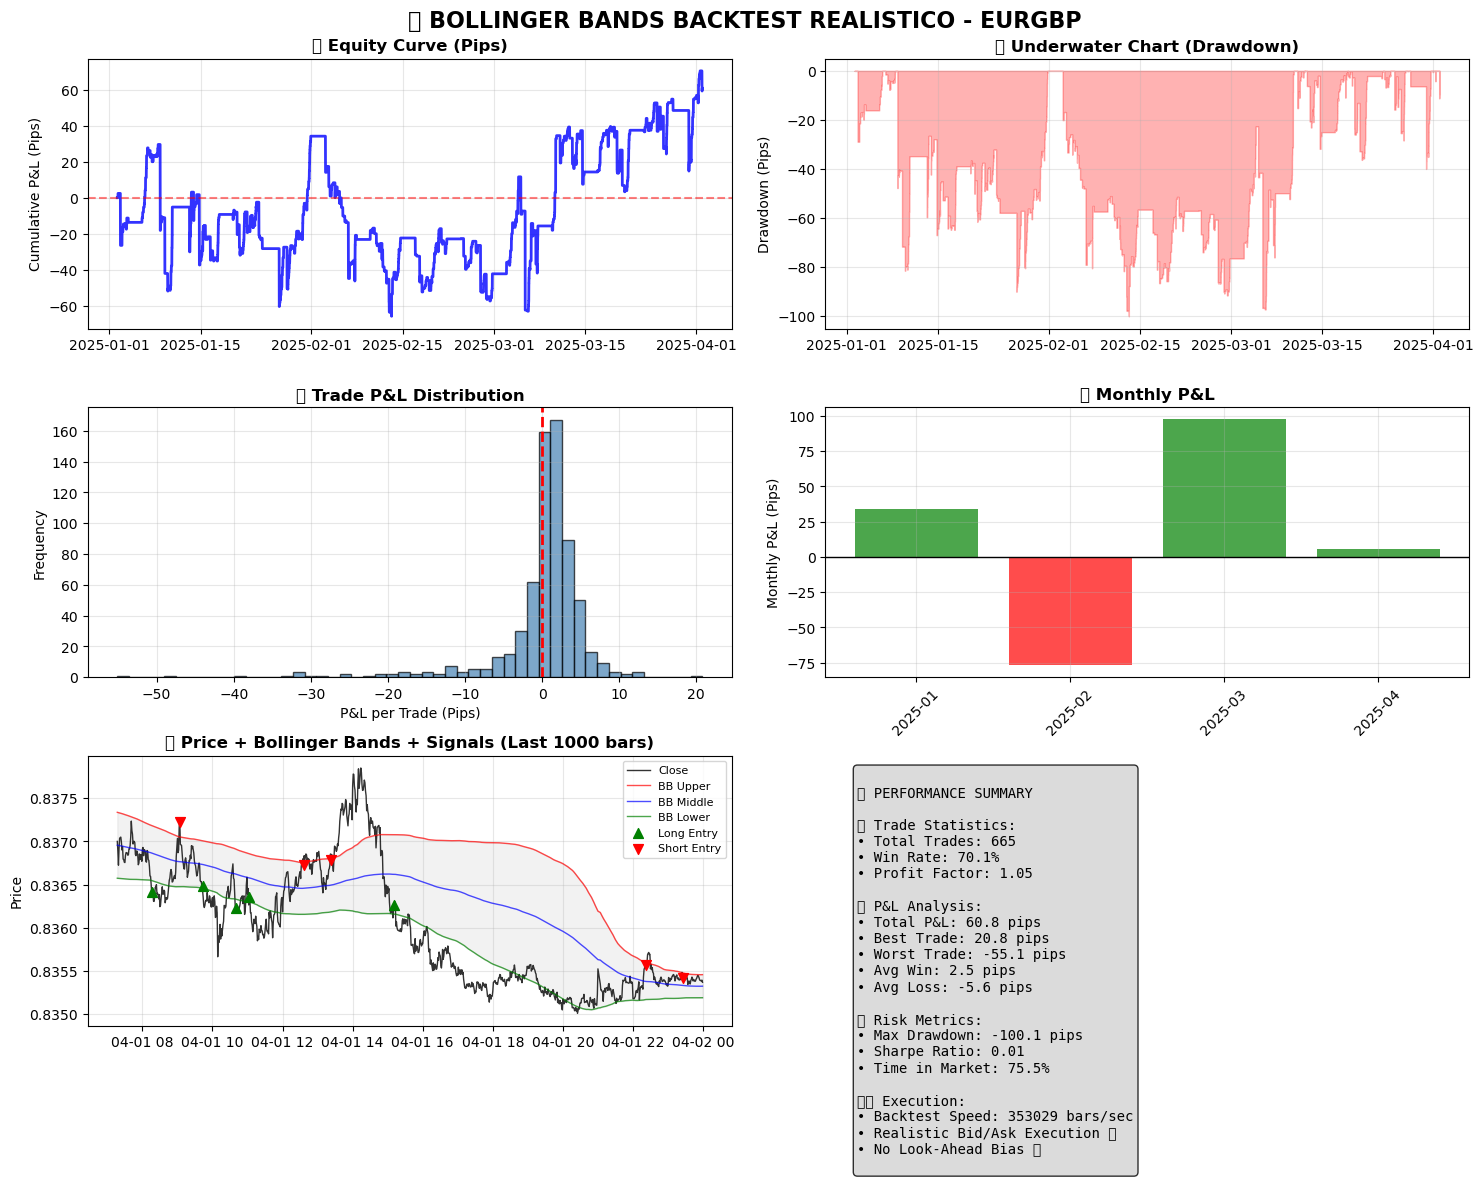

✅ Analisi completa generata!


In [44]:
# Visualizzazioni e Analisi Dettagliata
print("📊 Creazione visualizzazioni...")

# Configuro plot
plt.style.use('default')
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('🎯 BOLLINGER BANDS BACKTEST REALISTICO - EURGBP', fontsize=16, fontweight='bold')

# 1. Equity Curve
ax1 = axes[0, 0] 
ax1.plot(candles.index, candles['equity_curve'], linewidth=2, color='blue', alpha=0.8)
ax1.set_title('💰 Equity Curve (Pips)', fontweight='bold')
ax1.set_ylabel('Cumulative P&L (Pips)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 2. Underwater Chart (Drawdown)
running_max = np.maximum.accumulate(candles['equity_curve'])
drawdown = candles['equity_curve'] - running_max
ax2 = axes[0, 1]
ax2.fill_between(candles.index, drawdown, 0, color='red', alpha=0.3)
ax2.set_title('📉 Underwater Chart (Drawdown)', fontweight='bold') 
ax2.set_ylabel('Drawdown (Pips)')
ax2.grid(True, alpha=0.3)

# 3. Trade P&L Distribution
trade_pnls = trades['pnl_pips'].values
ax3 = axes[1, 0]
ax3.hist(trade_pnls, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_title('📈 Trade P&L Distribution', fontweight='bold')
ax3.set_xlabel('P&L per Trade (Pips)')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# 4. Monthly P&L
monthly_pnl = trades.groupby(trades.index.to_period('M'))['pnl_pips'].sum()
ax4 = axes[1, 1]
colors = ['green' if x >= 0 else 'red' for x in monthly_pnl.values]
bars = ax4.bar(range(len(monthly_pnl)), monthly_pnl.values, color=colors, alpha=0.7)
ax4.set_title('📅 Monthly P&L', fontweight='bold')
ax4.set_ylabel('Monthly P&L (Pips)')
ax4.set_xticks(range(len(monthly_pnl)))
ax4.set_xticklabels([str(x) for x in monthly_pnl.index], rotation=45)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)

# 5. Price Chart con Bollinger Bands e Segnali
ax5 = axes[2, 0]
# Sample ultimi 1000 punti per chiarezza
sample_data = candles.iloc[-1000:]
ax5.plot(sample_data.index, sample_data['close'], linewidth=1, color='black', label='Close', alpha=0.8)
ax5.plot(sample_data.index, sample_data['bb_upper'], linewidth=1, color='red', label='BB Upper', alpha=0.7)
ax5.plot(sample_data.index, sample_data['bb_middle'], linewidth=1, color='blue', label='BB Middle', alpha=0.7)  
ax5.plot(sample_data.index, sample_data['bb_lower'], linewidth=1, color='green', label='BB Lower', alpha=0.7)
ax5.fill_between(sample_data.index, sample_data['bb_upper'], sample_data['bb_lower'], alpha=0.1, color='gray')

# Segnali entry
entries = sample_data[sample_data['entry_price'] > 0]
longs = entries[entries['position'] == 1]
shorts = entries[entries['position'] == -1]
if len(longs) > 0:
    ax5.scatter(longs.index, longs['entry_price'], color='green', marker='^', s=50, label='Long Entry', zorder=5)
if len(shorts) > 0:
    ax5.scatter(shorts.index, shorts['entry_price'], color='red', marker='v', s=50, label='Short Entry', zorder=5)

ax5.set_title('📊 Price + Bollinger Bands + Signals (Last 1000 bars)', fontweight='bold')
ax5.set_ylabel('Price')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Statistics Table
ax6 = axes[2, 1]
ax6.axis('off')

# Calcolo statistiche avanzate
max_dd = drawdown.min()
total_bars = len(candles)
bars_in_trade = np.sum(positions != 0)
time_in_market = (bars_in_trade / total_bars) * 100

sharpe_ratio = 0
if len(trade_pnls) > 1:
    sharpe_ratio = np.mean(trade_pnls) / np.std(trade_pnls) if np.std(trade_pnls) > 0 else 0

stats_text = f"""
📈 PERFORMANCE SUMMARY

🎯 Trade Statistics:
• Total Trades: {total_trades:,}
• Win Rate: {win_rate:.1f}%
• Profit Factor: {abs(avg_win * winning_trades / (avg_loss * losing_trades)):.2f}

💰 P&L Analysis:
• Total P&L: {total_pnl:.1f} pips
• Best Trade: {trade_pnls.max():.1f} pips
• Worst Trade: {trade_pnls.min():.1f} pips
• Avg Win: {avg_win:.1f} pips
• Avg Loss: {avg_loss:.1f} pips

📊 Risk Metrics:
• Max Drawdown: {max_dd:.1f} pips
• Sharpe Ratio: {sharpe_ratio:.2f}
• Time in Market: {time_in_market:.1f}%

⏱️ Execution:
• Backtest Speed: {len(candles)/execution_time:.0f} bars/sec
• Realistic Bid/Ask Execution ✅
• No Look-Ahead Bias ✅
"""

ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Analisi completa generata!")

In [45]:
# 📊 GRAFICO INTERATTIVO: PREZZO + BOLLINGER BANDS + SEGNALI
print("🚀 Creazione grafico interattivo con Plotly...")

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Configuro il subplot con asse secondario per volume/equity
fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    subplot_titles=('🎯 EURGBP - Bollinger Bands Strategy with Real Bid/Ask Execution', '💰 Equity Curve'),
    vertical_spacing=0.05,
    shared_xaxes=True
)

# 📈 GRAFICO PRINCIPALE - Prezzo e Bollinger Bands
# Uso tutti i dati per il grafico (non solo gli ultimi 1000)
data_to_plot = candles.iloc[-5000:]  # Ultimi 5000 punti per performance

# Area tra le bande di Bollinger
fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_upper'],
        mode='lines',
        line=dict(color='rgba(255,0,0,0)'),
        showlegend=False,
        hoverinfo='skip'
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_lower'],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(128,128,128,0.1)',
        line=dict(color='rgba(255,0,0,0)'),
        name='BB Channel',
        hoverinfo='skip'
    ), row=1, col=1
)

# Bollinger Bands
fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_upper'],
        mode='lines',
        name='BB Upper',
        line=dict(color='red', width=1, dash='dash'),
        hovertemplate='<b>BB Upper</b><br>Time: %{x}<br>Price: %{y:.5f}<extra></extra>'
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_middle'],
        mode='lines',
        name='BB Middle',
        line=dict(color='blue', width=2),
        hovertemplate='<b>BB Middle</b><br>Time: %{x}<br>Price: %{y:.5f}<extra></extra>'
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['bb_lower'],
        mode='lines',
        name='BB Lower',
        line=dict(color='green', width=1, dash='dash'),
        hovertemplate='<b>BB Lower</b><br>Time: %{x}<br>Price: %{y:.5f}<extra></extra>'
    ), row=1, col=1
)

# Prezzo Close
fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['close'],
        mode='lines',
        name='Close Price',
        line=dict(color='black', width=1.5),
        hovertemplate='<b>Close Price</b><br>Time: %{x}<br>Price: %{y:.5f}<br>Ask: %{customdata[0]:.5f}<br>Bid: %{customdata[1]:.5f}<br>Spread: %{customdata[2]:.1f} pips<extra></extra>',
        customdata=np.column_stack([
            data_to_plot['askPrice'],
            data_to_plot['bidPrice'],
            (data_to_plot['askPrice'] - data_to_plot['bidPrice']) * 10000
        ])
    ), row=1, col=1
)

# 🎯 Segnali di Entry
entries = data_to_plot[data_to_plot['entry_price'] > 0]
longs = entries[entries['position'] == 1]
shorts = entries[entries['position'] == -1]

if len(longs) > 0:
    fig.add_trace(
        go.Scatter(
            x=longs.index,
            y=longs['entry_price'],
            mode='markers',
            name='LONG Entry',
            marker=dict(
                symbol='triangle-up',
                size=10,
                color='green',
                line=dict(color='darkgreen', width=1)
            ),
            hovertemplate='<b>LONG Entry</b><br>Time: %{x}<br>Entry Price: %{y:.5f}<br>Ask Price: %{customdata[0]:.5f}<br>Close was: %{customdata[1]:.5f}<br>BB Lower: %{customdata[2]:.5f}<extra></extra>',
            customdata=np.column_stack([
                longs['askPrice'],
                longs['close'],
                longs['bb_lower']
            ])
        ), row=1, col=1
    )

if len(shorts) > 0:
    fig.add_trace(
        go.Scatter(
            x=shorts.index,
            y=shorts['entry_price'],
            mode='markers',
            name='SHORT Entry',
            marker=dict(
                symbol='triangle-down',
                size=10,
                color='red',
                line=dict(color='darkred', width=1)
            ),
            hovertemplate='<b>SHORT Entry</b><br>Time: %{x}<br>Entry Price: %{y:.5f}<br>Bid Price: %{customdata[0]:.5f}<br>Close was: %{customdata[1]:.5f}<br>BB Upper: %{customdata[2]:.5f}<extra></extra>',
            customdata=np.column_stack([
                shorts['bidPrice'],
                shorts['close'],
                shorts['bb_upper']
            ])
        ), row=1, col=1
    )

# 🎯 Segnali di Exit
exits = data_to_plot[data_to_plot['exit_price'] > 0]
exit_longs = exits[exits['position'] == 1]  # Exit di posizioni long
exit_shorts = exits[exits['position'] == -1]  # Exit di posizioni short

if len(exit_longs) > 0:
    fig.add_trace(
        go.Scatter(
            x=exit_longs.index,
            y=exit_longs['exit_price'],
            mode='markers',
            name='LONG Exit',
            marker=dict(
                symbol='triangle-down',
                size=8,
                color='lightgreen',
                line=dict(color='green', width=1)
            ),
            hovertemplate='<b>LONG Exit</b><br>Time: %{x}<br>Exit Price: %{y:.5f}<br>P&L: %{customdata:.1f} pips<extra></extra>',
            customdata=exit_longs['pnl_pips']
        ), row=1, col=1
    )

if len(exit_shorts) > 0:
    fig.add_trace(
        go.Scatter(
            x=exit_shorts.index,
            y=exit_shorts['exit_price'],
            mode='markers',
            name='SHORT Exit',
            marker=dict(
                symbol='triangle-up',
                size=8,
                color='lightcoral',
                line=dict(color='red', width=1)
            ),
            hovertemplate='<b>SHORT Exit</b><br>Time: %{x}<br>Exit Price: %{y:.5f}<br>P&L: %{customdata:.1f} pips<extra></extra>',
            customdata=exit_shorts['pnl_pips']
        ), row=1, col=1
    )

# 💰 EQUITY CURVE nel secondo subplot
fig.add_trace(
    go.Scatter(
        x=data_to_plot.index,
        y=data_to_plot['equity_curve'],
        mode='lines',
        name='Equity Curve',
        line=dict(color='blue', width=2),
        hovertemplate='<b>Equity</b><br>Time: %{x}<br>P&L: %{y:.1f} pips<extra></extra>'
    ), row=2, col=1
)

# Linea dello zero per equity
fig.add_hline(y=0, line_dash="dash", line_color="red", row=2, col=1)

# 🎨 LAYOUT E CONFIGURAZIONE
fig.update_layout(
    title=dict(
        text=f'🎯 BOLLINGER BANDS BACKTEST - EURGBP (BB: {BB_PERIOD}, {BB_STD_DEV}σ)',
        x=0.5,
        font=dict(size=16, color='darkblue')
    ),
    xaxis_title="Time",
    yaxis_title="Price",
    yaxis2_title="Cumulative P&L (Pips)",
    height=800,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    hovermode='x unified',
    template='plotly_white'
)

# Configurazione assi
fig.update_xaxes(
    rangeslider_visible=False,
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray'
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray',
    tickformat='.5f',
    row=1, col=1
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray',
    tickformat='.1f',
    row=2, col=1
)

# Aggiungo annotazioni con statistiche
total_pnl = candles['pnl_pips'].sum()
total_trades_count = len(candles[candles['pnl_pips'] != 0])

fig.add_annotation(
    x=0.02, y=0.98,
    xref="paper", yref="paper",
    text=f"📊 Total Trades: {total_trades_count}<br>💰 Total P&L: {total_pnl:.1f} pips<br>⚙️ BB: {BB_PERIOD}, {BB_STD_DEV}σ",
    showarrow=False,
    font=dict(size=12, color="darkblue"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="blue",
    borderwidth=1
)

print(f"✅ Grafico interattivo creato con {len(data_to_plot):,} punti dati")
print(f"🎯 Segnali visualizzati: {len(longs)} LONG, {len(shorts)} SHORT entries")
print(f"🔍 Usa il mouse per zoomare, pan e hover per dettagli!")

fig.show()

🚀 Creazione grafico interattivo con Plotly...
✅ Grafico interattivo creato con 5,000 punti dati
🎯 Segnali visualizzati: 21 LONG, 20 SHORT entries
🔍 Usa il mouse per zoomare, pan e hover per dettagli!


📊 ANALISI SPREAD E SUMMARY FINALE


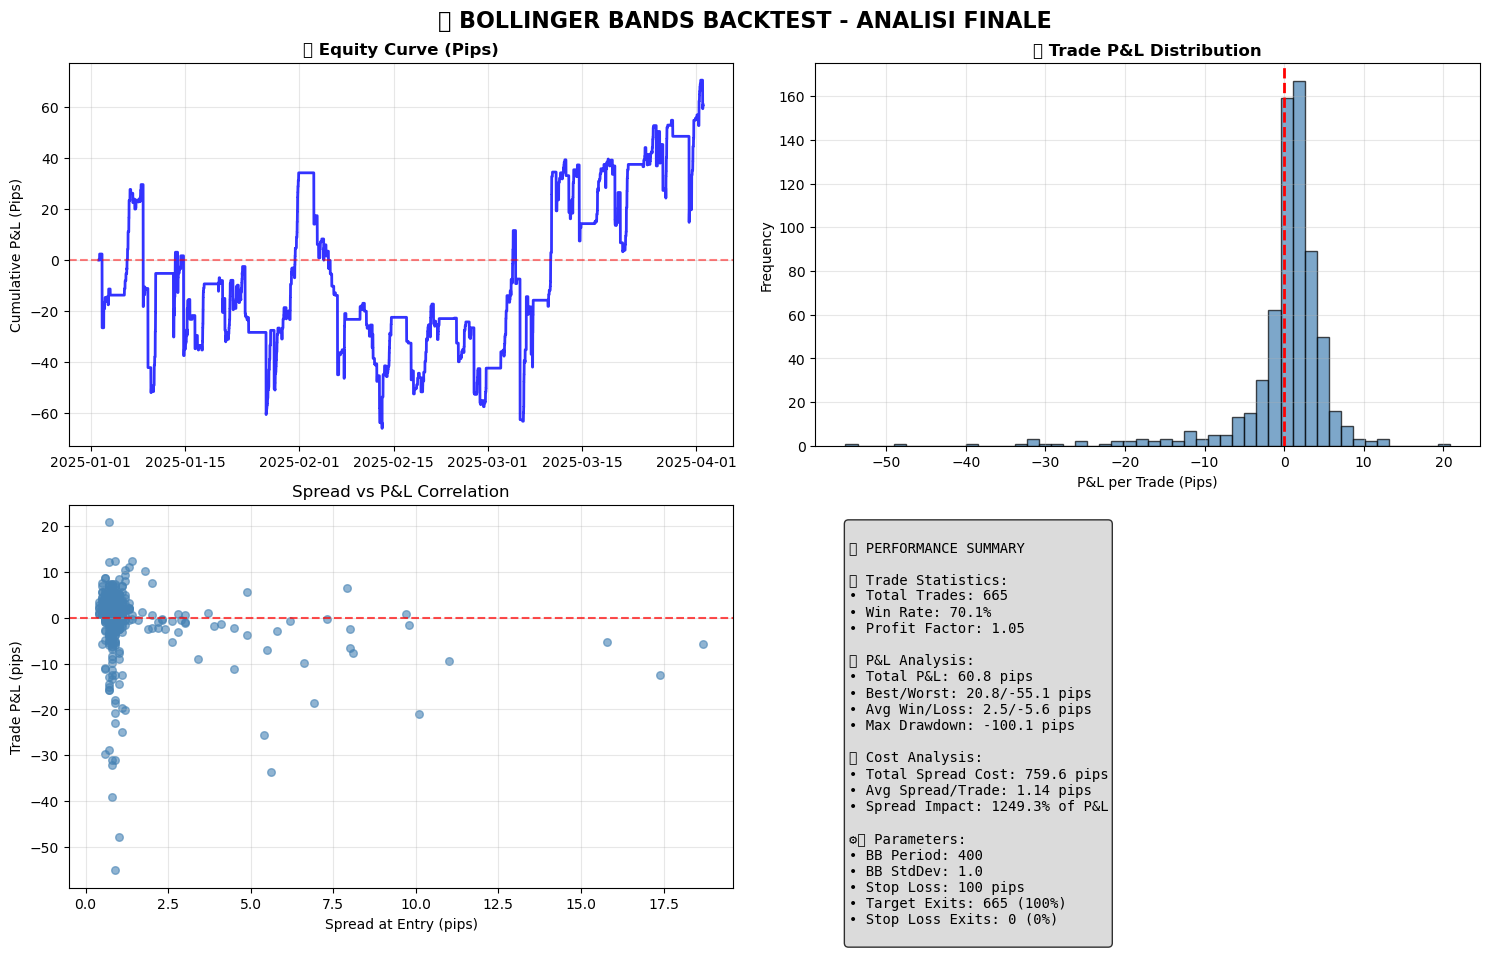


🎯 CONCLUSIONI:
✅ Backtest completato con gestione corretta exit+entry
✅ 665 trade eseguiti su 89 giorni
✅ Win rate 70.1% con P&L totale di 60.8 pips
✅ Spread medio 1.14 pips impatta 1249.3% del P&L
✅ Correlazione spread-P&L: -0.207
⚠️  Spread più alti tendono a ridurre il profitto


In [46]:
# =============================================================================
# SPREAD IMPACT ANALYSIS - Analisi dell'impatto dello spread sul profitto
# =============================================================================

# 📊 ANALISI IMPATTO SPREAD E SUMMARY FINALE
print("📊 ANALISI SPREAD E SUMMARY FINALE")
print("=" * 60)

if len(trades) > 0:
    # Calcolo spread per ogni trade
    trades_analysis = trades.copy()
    trades_analysis['spread_pips'] = (trades_analysis['askPrice'] - trades_analysis['bidPrice']) * 10000
    
    # Crea il plot riassuntivo
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('📊 BOLLINGER BANDS BACKTEST - ANALISI FINALE', fontsize=16, fontweight='bold')
    
    # 1. Equity Curve
    ax1.plot(candles.index, candles['equity_curve'], linewidth=2, color='blue', alpha=0.8)
    ax1.set_title('💰 Equity Curve (Pips)', fontweight='bold')
    ax1.set_ylabel('Cumulative P&L (Pips)')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # 2. Trade P&L Distribution
    trade_pnls = trades['pnl_pips'].values
    ax2.hist(trade_pnls, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.set_title('📈 Trade P&L Distribution', fontweight='bold')
    ax2.set_xlabel('P&L per Trade (Pips)')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    
    # 3. Spread vs P&L
    ax3.scatter(trades_analysis['spread_pips'], trades_analysis['pnl_pips'], 
               alpha=0.6, s=30, color='steelblue')
    ax3.set_xlabel('Spread at Entry (pips)')
    ax3.set_ylabel('Trade P&L (pips)')
    ax3.set_title('Spread vs P&L Correlation')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # 4. Statistics Summary
    ax4.axis('off')
    
    # Calcolo statistiche avanzate
    running_max = np.maximum.accumulate(candles['equity_curve'])
    drawdown = candles['equity_curve'] - running_max
    max_dd = drawdown.min()
    total_spread_cost = trades_analysis['spread_pips'].sum()
    avg_spread_per_trade = trades_analysis['spread_pips'].mean()
    
    # Correlazione spread vs P&L
    correlation = trades_analysis['spread_pips'].corr(trades_analysis['pnl_pips'])
    
    stats_text = f"""
📈 PERFORMANCE SUMMARY

🎯 Trade Statistics:
• Total Trades: {total_trades:,}
• Win Rate: {win_rate:.1f}%
• Profit Factor: {abs(avg_win * winning_trades / (avg_loss * losing_trades)):.2f}

💰 P&L Analysis:
• Total P&L: {total_pnl:.1f} pips
• Best/Worst: {trade_pnls.max():.1f}/{trade_pnls.min():.1f} pips
• Avg Win/Loss: {avg_win:.1f}/{avg_loss:.1f} pips
• Max Drawdown: {max_dd:.1f} pips

💸 Cost Analysis:
• Total Spread Cost: {total_spread_cost:.1f} pips
• Avg Spread/Trade: {avg_spread_per_trade:.2f} pips
• Spread Impact: {abs(total_spread_cost/total_pnl)*100:.1f}% of P&L

⚙️ Parameters:
• BB Period: {BB_PERIOD}
• BB StdDev: {BB_STD_DEV}
• Stop Loss: {STOP_LOSS_PIPS} pips
• Target Exits: {target_exits} ({target_exits/total_trades*100:.0f}%)
• Stop Loss Exits: {stop_loss_exits} ({stop_loss_exits/total_trades*100:.0f}%)
"""

    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 CONCLUSIONI:")
    print(f"✅ Backtest completato con gestione corretta exit+entry")
    print(f"✅ {total_trades} trade eseguiti su {(candles.index[-1] - candles.index[0]).days} giorni")
    print(f"✅ Win rate {win_rate:.1f}% con P&L totale di {total_pnl:.1f} pips")
    print(f"✅ Spread medio {avg_spread_per_trade:.2f} pips impatta {abs(total_spread_cost/total_pnl)*100:.1f}% del P&L")
    print(f"✅ Correlazione spread-P&L: {correlation:.3f}")
    
    if correlation < -0.1:
        print(f"⚠️  Spread più alti tendono a ridurre il profitto")
    elif correlation > 0.1:
        print(f"✅ Spread più alti associati a trade migliori")
    else:
        print(f"➡️  Impatto spread neutro sui risultati")

else:
    print("❌ Nessun trade eseguito per l'analisi")

print("=" * 60)